In [ ]:
import os
import sys
import time
import random
import logging
import warnings

import numpy as np
import pandas as pd
import cv2
from PIL import Image
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast

import torchvision
import torchvision.models as models
from torchvision.transforms import v2
from torchvision.transforms import InterpolationMode
from torchvision.transforms.v2 import InterpolationMode

import timm
from timm import create_model

import albumentations as A
from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img import retrieve_latents

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from multiprocessing import Pool, cpu_count
from tqdm import tqdm

logging.basicConfig(level=logging.INFO)
_logger = logging.getLogger(__name__)

warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

# Configuration and Reproducibility

In [2]:
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [ ]:
class CFG:
    lr = 1e-4
    batch_size = 32
    img_size = (512, 512)
    seed = 42
    epochs = 7
    root_dir = '/kaggle/input/ai-vs-human-generated-dataset'
    test_df = os.path.join(root_dir, 'test.csv')
    train_df = os.path.join(root_dir, 'train.csv')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    checkpoint_path = 'models/SimpleFIRE_Model.pth'
    train_data_path = '/kaggle/input/ai-vs-human-generated-dataset/train'  
    test_data_path = '/kaggle/input/ai-vs-human-generated-dataset/'
    test_csv_path = '/kaggle/input/ai-vs-human-generated-dataset/test.csv'
    submission_path = 'submission.csv'
    mixed_precision = False  
    num_workers = 8
    pin_memory = True
    weight_decay = 1e-5
    num_classes = 2
    patch_size = 32
    gamma = 0.7
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Vizualize

In [4]:
train_df = pd.read_csv(CFG.train_df)
train_df = train_df.drop(['Unnamed: 0'], axis = 1)
train_df['file_name'] = train_df['file_name'].apply(lambda x: os.path.join(CFG.root_dir, x))

print("Original label distribution:")
print(train_df['label'].value_counts())

total_samples = 20000
classes = train_df['label'].unique()  # Get unique labels (e.g., [0, 1])
samples_per_class = total_samples // len(classes)

train_df_balanced = pd.concat([
    train_df[train_df['label'] == cls].sample(n=samples_per_class, random_state=42)
    for cls in classes
])

train_df_balanced = train_df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nNew label distribution:")
print(train_df_balanced['label'].value_counts())

print("\nFirst 10 rows of balanced dataframe:")
print(train_df_balanced.head(10))

train_df = train_df_balanced
train_df.head(10)

Original label distribution:
label
1    39975
0    39975
Name: count, dtype: int64

New label distribution:
label
0    10000
1    10000
Name: count, dtype: int64

First 10 rows of balanced dataframe:
                                           file_name  label
0  /kaggle/input/ai-vs-human-generated-dataset/tr...      0
1  /kaggle/input/ai-vs-human-generated-dataset/tr...      1
2  /kaggle/input/ai-vs-human-generated-dataset/tr...      1
3  /kaggle/input/ai-vs-human-generated-dataset/tr...      1
4  /kaggle/input/ai-vs-human-generated-dataset/tr...      0
5  /kaggle/input/ai-vs-human-generated-dataset/tr...      0
6  /kaggle/input/ai-vs-human-generated-dataset/tr...      0
7  /kaggle/input/ai-vs-human-generated-dataset/tr...      1
8  /kaggle/input/ai-vs-human-generated-dataset/tr...      0
9  /kaggle/input/ai-vs-human-generated-dataset/tr...      1


file_name  label
0  /kaggle/input/ai-vs-human-generated-dataset/tr...      0
1  /kaggle/input/ai-vs-human-generated-dataset/tr...      1
2  /kaggle/input/ai-vs-human-generated-dataset/tr...      1
3  /kaggle/input/ai-vs-human-generated-dataset/tr...      1
4  /kaggle/input/ai-vs-human-generated-dataset/tr...      0
5  /kaggle/input/ai-vs-human-generated-dataset/tr...      0
6  /kaggle/input/ai-vs-human-generated-dataset/tr...      0
7  /kaggle/input/ai-vs-human-generated-dataset/tr...      1
8  /kaggle/input/ai-vs-human-generated-dataset/tr...      0
9  /kaggle/input/ai-vs-human-generated-dataset/tr...      1

In [5]:
test_df = pd.read_csv(CFG.test_df)
test_df['id'] = test_df['id'].apply(lambda x: os.path.join(CFG.root_dir, x))
test_df.head()

id
0  /kaggle/input/ai-vs-human-generated-dataset/te...
1  /kaggle/input/ai-vs-human-generated-dataset/te...
2  /kaggle/input/ai-vs-human-generated-dataset/te...
3  /kaggle/input/ai-vs-human-generated-dataset/te...
4  /kaggle/input/ai-vs-human-generated-dataset/te...

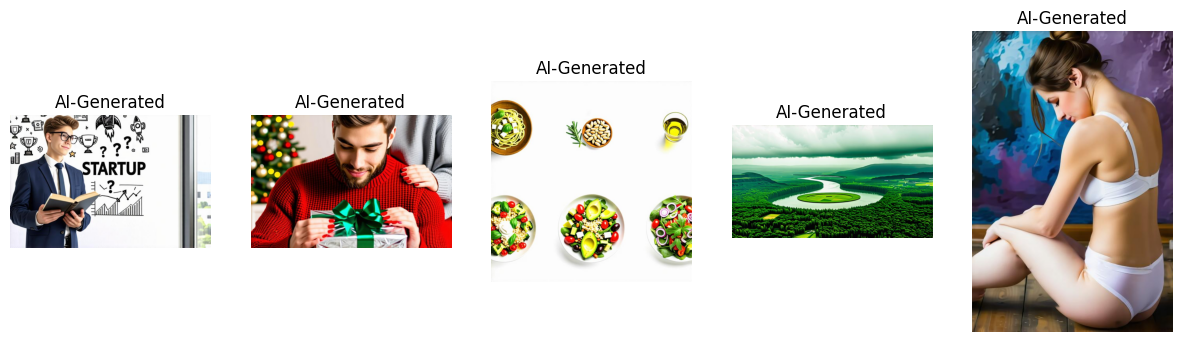

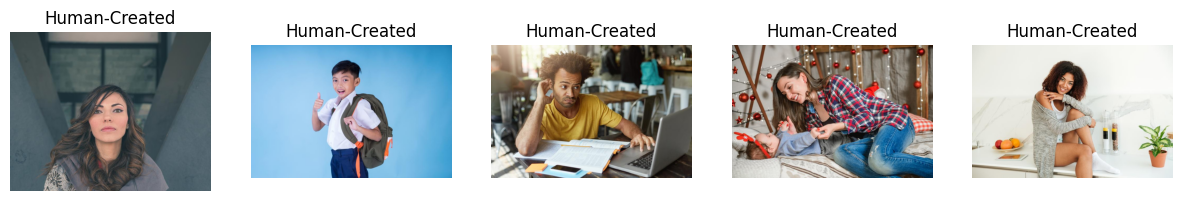

In [6]:
def plot_samples(df, num_img = 5, label = 0):
    samples = df[df['label'] == label].sample(num_img)['file_name'].values

    plt.figure(figsize = (15, 5))

    for i, path in enumerate(samples):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_img, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title("AI-Generated" if label == 1 else "Human-Created")

    plt.show()


plot_samples(train_df, label = 1)
plot_samples(train_df, label = 0)

# EDA

In [7]:
def process_image_size(row):
    """Helper function for parallel size processing"""
    try:
        img = cv2.imread(row['file_name'], cv2.IMREAD_GRAYSCALE)
        if img is not None:
            return (row['label'], img.shape[1], img.shape[0])  # width, height
        return None
    except:
        return None

def process_image_brightness(row):
    """Helper function for parallel brightness processing"""
    try:
        img = cv2.imread(row['file_name'], cv2.IMREAD_GRAYSCALE)
        if img is not None:
            return (row['label'], np.mean(img))
        return None
    except:
        return None

In [8]:
def plot_image_size_distribution(df, num_workers=None, max_images=5000):
    """Optimized image size distribution plot with image limit"""
    if num_workers is None:
        num_workers = cpu_count()  
    if len(df) > max_images:
        sampled_df = df.sample(n=max_images, random_state=42)  # random_state for reproducibility
    else:
        sampled_df = df
    
    with Pool(num_workers) as pool:
        results = pool.map(process_image_size, [row for _, row in sampled_df.iterrows()])
    
    results = [r for r in results if r is not None]
    human_widths = [r[1] for r in results if r[0] == 0]
    human_heights = [r[2] for r in results if r[0] == 0]
    ai_widths = [r[1] for r in results if r[0] == 1]
    ai_heights = [r[2] for r in results if r[0] == 1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    sns.histplot(human_widths, ax=ax1, color='blue', label='Human', alpha=0.5)
    sns.histplot(ai_widths, ax=ax1, color='red', label='AI', alpha=0.5)
    ax1.set_title(f'Width Distribution (Max {max_images} Images)')
    ax1.set_xlabel('Width (pixels)')
    ax1.legend()
    
    sns.histplot(human_heights, ax=ax2, color='blue', label='Human', alpha=0.5)
    sns.histplot(ai_heights, ax=ax2, color='red', label='AI', alpha=0.5)
    ax2.set_title(f'Height Distribution (Max {max_images} Images)')
    ax2.set_xlabel('Height (pixels)')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

In [9]:
def plot_brightness_distribution(df, num_workers=None, max_images=5000):
    """Optimized brightness distribution plot with image limit"""
    if num_workers is None:
        num_workers = cpu_count()  
    if len(df) > max_images:
        sampled_df = df.sample(n=max_images, random_state=42)  # random_state for reproducibility
    else:
        sampled_df = df
    
    with Pool(num_workers) as pool:
        results = pool.map(process_image_brightness, [row for _, row in sampled_df.iterrows()])
    
    results = [r for r in results if r is not None]
    human_brightness = [r[1] for r in results if r[0] == 0]
    ai_brightness = [r[1] for r in results if r[0] == 1]
    
    plt.figure(figsize=(10, 6))
    
    sns.histplot(human_brightness, color='blue', label='Human', alpha=0.5)
    sns.histplot(ai_brightness, color='red', label='AI', alpha=0.5)
    
    plt.title(f'Brightness Distribution by Class (Max {max_images} Images)')
    plt.xlabel('Mean Brightness (0-255)')
    plt.ylabel('Count')
    
    human_mean = np.mean(human_brightness)
    ai_mean = np.mean(ai_brightness)
    plt.axvline(human_mean, color='blue', linestyle='--', label=f'Human Mean: {human_mean:.1f}')
    plt.axvline(ai_mean, color='red', linestyle='--', label=f'AI Mean: {ai_mean:.1f}')
    
    plt.legend()
    plt.tight_layout()
    plt.show()

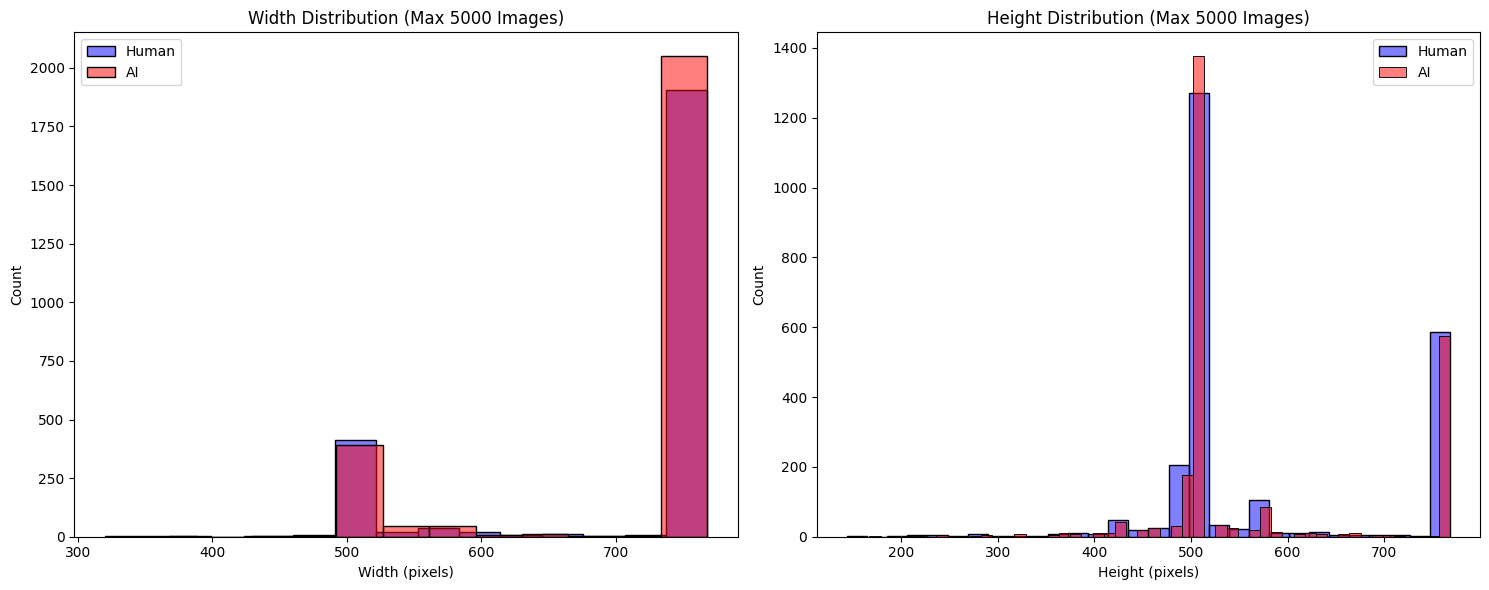

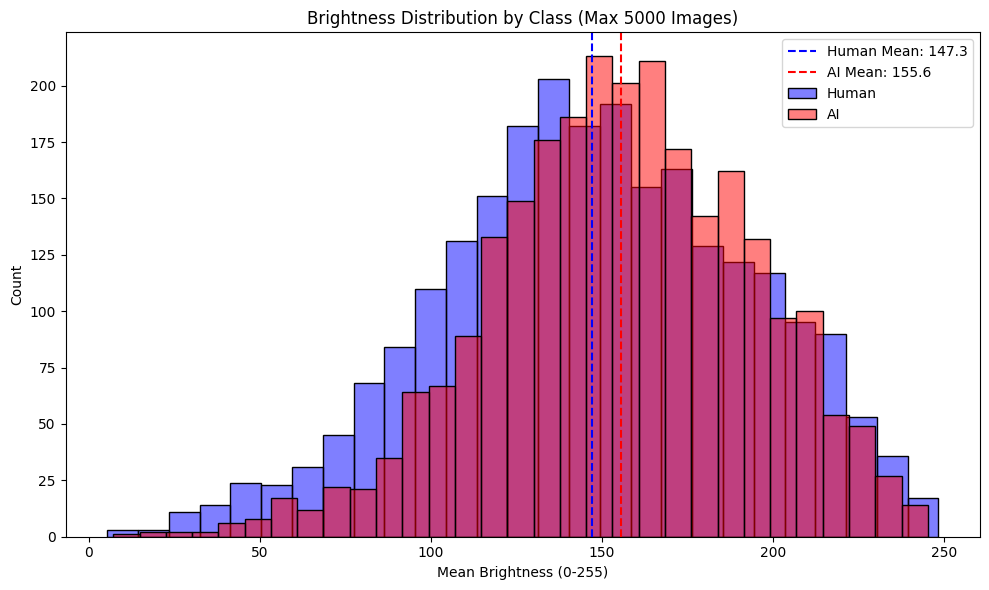

In [10]:
plot_image_size_distribution(train_df, max_images = 5000)
plot_brightness_distribution(train_df, max_images = 5000)

In [11]:
# plot_image_size_distribution(test_df, max_images = len(test_df))
# plot_brightness_distribution(test_df, max_images = len(test_df))

In [13]:
train_transforms = v2.Compose([
    v2.Resize(512, interpolation=InterpolationMode.BICUBIC),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomApply([
        v2.RandomResizedCrop(
            size=(512, 512),
            scale=(0.08, 1.0),
            ratio=(0.75, 1.3333),
            interpolation=InterpolationMode.BICUBIC
        )
    ], p=0.2),
    v2.RandomCrop(size=(512, 512)),
    v2.RandomApply([
        v2.ColorJitter(
            brightness=0.04,
            contrast=0.04,
            saturation=0.04,
            hue=0.1
        )
    ], p=0.8),
    v2.ToTensor(),
    v2.RandomGrayscale(p=0.2),
    v2.RandomErasing(
        p=0.2,
        scale=(96/512, 96/512),
        ratio=(1.0, 1.0),
        value=128/255
    ),
    v2.RandomApply([
        v2.GaussianNoise(
            mean=0.0,
            sigma=30.0**0.5/255
        )
    ], p=0.8),
    v2.GaussianBlur(kernel_size=23),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = v2.Compose([
    v2.Resize(512, interpolation=InterpolationMode.BICUBIC),
    v2.CenterCrop(512),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset Implementation

In [14]:
class AIvsHumanDataset(Dataset):
    def __init__(self, df, transforms=None, is_test=False):
        self.df = df
        self.transforms = transforms
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['file_name']
        img = Image.open(img_path).convert('RGB')
        
        if self.transforms:
            img = self.transforms(img)
            
        if self.is_test:
            return img
        else:
            label = self.df.iloc[idx]['label']  
            return img, label

In [15]:
train_df, val_df = train_test_split(
    train_df,  
    test_size=0.05,        
    stratify=train_df['label'],  
    random_state=42
)

In [16]:
def create_convnext_model():
    model = models.convnext_large(weights=models.ConvNeXt_Large_Weights.IMAGENET1K_V1)
    num_ftrs = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(num_ftrs, 2)
    model.to(CFG.device)
    
    return model

In [17]:
def create_regnet_model():
    model = models.regnet_y_32gf(weights=models.RegNet_Y_32GF_Weights.IMAGENET1K_SWAG_E2E_V1)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
    model.to(CFG.device)
    
    return model

In [ ]:
class FrequencyFilter(nn.Module):
    def __init__(self, radiuslow=40, radiushigh=120):
        super(FrequencyFilter, self).__init__()
        self.radiuslow = radiuslow
        self.radiushigh = radiushigh
        
    def forward(self, image):
        freq_image = torch.fft.fftn(image, dim=(-2, -1))
        freq_image = torch.fft.fftshift(freq_image, dim=(-2, -1))
        
        b, c, h, w = freq_image.shape
        y_grid, x_grid = torch.meshgrid(torch.arange(h), torch.arange(w), indexing='ij')
        y_grid = y_grid.to(freq_image.device)
        x_grid = x_grid.to(freq_image.device)
        
        center_y, center_x = h // 2, w // 2
        dist_from_center = torch.sqrt((y_grid - center_y)**2 + (x_grid - center_x)**2)
        
        mid_mask = torch.zeros((h, w), device=freq_image.device)
        mid_mask[(dist_from_center >= self.radiuslow) & (dist_from_center < self.radiushigh)] = 1
        
        mid_freq = freq_image * mid_mask.unsqueeze(0).unsqueeze(0)
        
        mid_freq = torch.fft.ifftshift(mid_freq, dim=(-2, -1))
        mid_freq_spatial = torch.abs(torch.fft.ifftn(mid_freq, dim=(-2, -1)))
        
        mid_freq_spatial = (mid_freq_spatial - mid_freq_spatial.min() + 1e-8) / (mid_freq_spatial.max() - mid_freq_spatial.min() + 1e-8)
        
        return mid_freq_spatial


class SimplifiedFIRE(nn.Module):
    def __init__(self, pretrained=True):
        super(SimplifiedFIRE, self).__init__()
        self.backbone = torchvision.models.resnet18(weights="IMAGENET1K_V1" if pretrained else None)
        
        original_weight = self.backbone.conv1.weight.clone()
        self.backbone.conv1 = nn.Conv2d(6, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        if pretrained:
            with torch.no_grad():
                self.backbone.conv1.weight[:, :3] = original_weight
                self.backbone.conv1.weight[:, 3:] = original_weight
        
        self.backbone.fc = nn.Linear(512, 2)
        
        self.freq_filter = FrequencyFilter(radiuslow=30, radiushigh=100)
        
    def forward(self, x):
        mid_freq_image = self.freq_filter(x)

        combined_features = torch.cat([x, mid_freq_image], dim=1)
        
        out = self.backbone(combined_features)
        
        return out

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device, scaler=None):
    model.train()
    train_loss = 0.0
    preds_list = []
    labels_list = []
    
    pbar = tqdm(loader, desc="Training")
    for images, labels in pbar:
        images, labels = images.to(CFG.device), labels.to(CFG.device)

        assert labels.max() < 2 and labels.min() >= 0, "Labels out of range (expected 0 or 1 for binary classification)"

        labels = labels.long()

        optimizer.zero_grad()
        
        if CFG.mixed_precision and scaler is not None:
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
        optimizer.zero_grad()
        
        train_loss += loss.item() * images.size(0)
        
        _, preds = torch.max(outputs, 1)
        preds_list.append(preds.cpu().numpy())
        labels_list.append(labels.cpu().numpy())
        
        pbar.set_postfix({'batch_loss': loss.item()})
    
    train_loss = train_loss / len(loader.dataset)
    preds_all = np.concatenate(preds_list)
    labels_all = np.concatenate(labels_list)
    accuracy = accuracy_score(labels_all, preds_all)
    
    return train_loss, accuracy

def validate(model, loader, criterion, device):
    model.eval()
    val_loss = 0.0
    preds_list = []
    labels_list = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(CFG.device), labels.to(CFG.device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            
            _, preds = torch.max(outputs, 1)
            preds_list.append(preds.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
    
    val_loss = val_loss / len(loader.dataset)
    preds_all = np.concatenate(preds_list)
    labels_all = np.concatenate(labels_list)
    accuracy = accuracy_score(labels_all, preds_all)

    _logger.info(f'\nClassification Report:\n{classification_report(labels_all, preds_all)}')
    
    return val_loss, accuracy

In [ ]:
def train_model(train_df, val_df):
    train_dataset = AIvsHumanDataset(df=train_df, transforms=train_transforms)
    val_dataset = AIvsHumanDataset(df=val_df, transforms=test_transforms)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=CFG.batch_size, 
        shuffle=True, 
        num_workers=CFG.num_workers, 
        pin_memory=CFG.pin_memory
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=CFG.batch_size, 
        shuffle=False, 
        num_workers=CFG.num_workers, 
        pin_memory=CFG.pin_memory
    )
    
    model = SimplifiedFIRE(pretrained=True)
    model.to(CFG.device)

    # all_params = list(model.named_parameters())
    # total_params = len(all_params)
    # freeze_until = total_params - 10  # Keep the last 10 trainable
    
    # for idx, (name, param) in enumerate(all_params):
    #     if idx < freeze_until:
    #         param.requires_grad = False
    #     else:
    #         param.requires_grad = True
    
    # for name, param in model.named_parameters():
    #     _logger.info(f"Layer: {name}, Requires Grad: {param.requires_grad}")
    
    criterion = nn.CrossEntropyLoss().to(CFG.device)
    optimizer = optim.Adam(
        model.parameters(), 
        lr=1e-4, 
        weight_decay=CFG.weight_decay
    )
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, 
        step_size = 1,
        gamma = CFG.gamma
    )
    
    scaler = GradScaler() if CFG.mixed_precision else None
    
    best_val_acc = 0.0
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
    
    for epoch in range(CFG.epochs):
        _logger.info(f'Epoch {epoch+1}/{CFG.epochs}')
        
        train_loss, train_acc = train_one_epoch(
            model, train_loader, optimizer, criterion, CFG.device, scaler
        )
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        val_loss, val_acc = validate(model, val_loader, criterion, CFG.device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        scheduler.step()

        _logger.info(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        _logger.info(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            _logger.info(f'Saving best model with accuracy: {best_val_acc:.4f}')
            
            os.makedirs(os.path.dirname(CFG.checkpoint_path), exist_ok=True)
            
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                'best_val_acc': best_val_acc,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_accs': train_accs,
                'val_accs': val_accs,
            }, CFG.checkpoint_path)
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Val Accuracy')
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.show()
    
    return model, best_val_acc

In [ ]:
def plot_predictions(images, predictions, num_images=20):
    num_images = min(len(images), num_images)

    rows = (num_images + 4) // 5 
    fig, axes = plt.subplots(rows, 5, figsize=(20, 4 * rows))
    
    axes = axes.flatten()
    
    for i in range(num_images):
        img = images[i].permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        
        axes[i].imshow(img)
        axes[i].set_title(f"Predicted: {'AI' if predictions[i] == 1 else 'Human'}")
        axes[i].axis('off')

    for i in range(num_images, len(axes)):
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.show()

In [ ]:
def compute_color_histogram(image_path):
    image = cv2.imread(image_path)
    if image is None:
        _logger.error(f"Unable to read image at {image_path}")
        return None
    hist = cv2.calcHist([image], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])
    return hist.flatten().mean()

def process_image(row):
    image_path = row['full_path']
    hist_value = compute_color_histogram(image_path)
    return hist_value

def create_submission_with_post_processing(model, test_csv_path, test_data_path, df_train_real_imgs, confidence_percent=99.0, sample_size=5544):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if device.type == 'cuda':
        _logger.info(f"Using GPU: {torch.cuda.get_device_name(0)}")
    else:
        _logger.warning("GPU not available, falling back to CPU")
    
    model.to(device)
    model.eval()
    
    test_df = pd.read_csv(test_csv_path)
    test_df['file_name'] = test_df['id'].apply(lambda x: os.path.join(test_data_path, x))
    
    test_dataset = AIvsHumanDataset(df=test_df, transforms=test_transforms, is_test=True)
    test_loader = DataLoader(
        test_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=CFG.num_workers,
        pin_memory=True if device.type == 'cuda' else False
    )
    
    _logger.info("Running inference on test data...")
    predictions = []
    probabilities_list = []
    all_images = []
    
    with torch.no_grad():
        for images in tqdm(test_loader, desc="Predicting"):
            images = images.to(device)
            outputs = model(images)
            
            if isinstance(outputs, (tuple, list)):
                outputs = outputs[0]
                _logger.warning("Model returned a tuple; using first element as output.")
            
            probabilities = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            predictions.extend(preds.cpu().numpy().tolist())
            probabilities_list.extend(probabilities[:, 1].cpu().numpy().tolist())
            all_images.extend([img.cpu() for img in images])
    
    pred_labels = pd.DataFrame({
        'id': test_df['id'],
        'label': probabilities_list
    })
    pred_labels['full_path'] = test_df['file_name']
    
    initial_submission_path = '/kaggle/working/initial_pred_probabilities.csv'
    pred_labels.to_csv(initial_submission_path, index=False)
    _logger.info(f"Initial predictions saved at {initial_submission_path}")
    
    _logger.info("Starting post-processing with histogram analysis...")
    
    actual_sample_size = min(sample_size, len(df_train_real_imgs))
    if actual_sample_size < sample_size:
        _logger.warning(f"Requested sample_size ({sample_size}) exceeds available real images ({len(df_train_real_imgs)}). Using {actual_sample_size} instead.")
    
    real_samples = df_train_real_imgs.sample(actual_sample_size, random_state=60)
    real_samples['full_path'] = real_samples['file_name'].apply(lambda x: os.path.join(test_data_path, x))
    
    with Pool(processes=4) as pool:
        real_histogram_values = list(tqdm(
            pool.imap(process_image, [row for _, row in real_samples.iterrows()]),
            total=actual_sample_size,
            desc="Processing real images",
            unit="image"
        ))
    real_histogram_values = [v for v in real_histogram_values if v is not None]
    
    kde_real = stats.gaussian_kde(real_histogram_values)
    x_vals_real = np.linspace(min(real_histogram_values), max(real_histogram_values), 1000)
    y_vals_real = kde_real(x_vals_real)
    peak_x_real = x_vals_real[np.argmax(y_vals_real)]
    
    lower_percentile = (100 - confidence_percent) / 2
    upper_percentile = 100 - lower_percentile
    lower_percentile_real = np.percentile(real_histogram_values, lower_percentile)
    upper_percentile_real = np.percentile(real_histogram_values, upper_percentile)
    delta_value = max(abs(peak_x_real - lower_percentile_real), abs(upper_percentile_real - peak_x_real))
    
    lower_threshold_real = peak_x_real - delta_value
    upper_threshold_real = peak_x_real + delta_value
    _logger.info(f"Real images peak: {peak_x_real:.6f}, Thresholds: [{lower_threshold_real:.6f}, {upper_threshold_real:.6f}]")
    
    pred_labels['label_binary'] = np.where(pred_labels['label'] > 0.99, 1, -1)
    negative_label_images = pred_labels[pred_labels['label_binary'] == -1].copy()
    
    with Pool(processes=4) as pool:
        histogram_values = list(tqdm(
            pool.imap(process_image, [row for _, row in negative_label_images.iterrows()]),
            total=len(negative_label_images),
            desc="Processing mixed images",
            unit="image"
        ))
    histogram_values = [v for v in histogram_values if v is not None]
    
    kde_mixed = stats.gaussian_kde(histogram_values)
    x_vals_mixed = np.linspace(min(histogram_values), max(histogram_values), 1000)
    y_vals_mixed = kde_mixed(x_vals_mixed)
    peak_x_mixed = x_vals_mixed[np.argmax(y_vals_mixed)]
    
    lower_threshold_mixed = peak_x_mixed - delta_value
    upper_threshold_mixed = peak_x_mixed + delta_value
    
    classifications = np.array([0 if lower_threshold_mixed <= v <= upper_threshold_mixed else 1 for v in histogram_values])
    negative_label_images['peak_class'] = classifications
    _logger.info(f"Mixed images peak: {peak_x_mixed:.6f}, Classified as real: {np.sum(classifications == 0)}, as GenAI: {np.sum(classifications == 1)}")
    
    image_to_class = dict(zip(negative_label_images['id'], negative_label_images['peak_class']))
    for idx, row in pred_labels.iterrows():
        if row['id'] in image_to_class:
            pred_labels.at[idx, 'label_binary'] = 1 if image_to_class[row['id']] == 1 else 0
    
    submission_df = pd.DataFrame({
        'id': pred_labels['id'],
        'label': pred_labels['label_binary']
    })
    final_submission_path = CFG.submission_path
    submission_df.to_csv(final_submission_path, index=False)
    _logger.info(f"Final submission with post-processing saved at {final_submission_path}")
    
    plot_predictions(all_images, submission_df['label'].tolist(), num_images=20)
    
    return submission_df, real_histogram_values, histogram_values, classifications

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 200MB/s]
Validation: 100%|██████████| 32/32 [00:07<00:00,  4.25it/s]


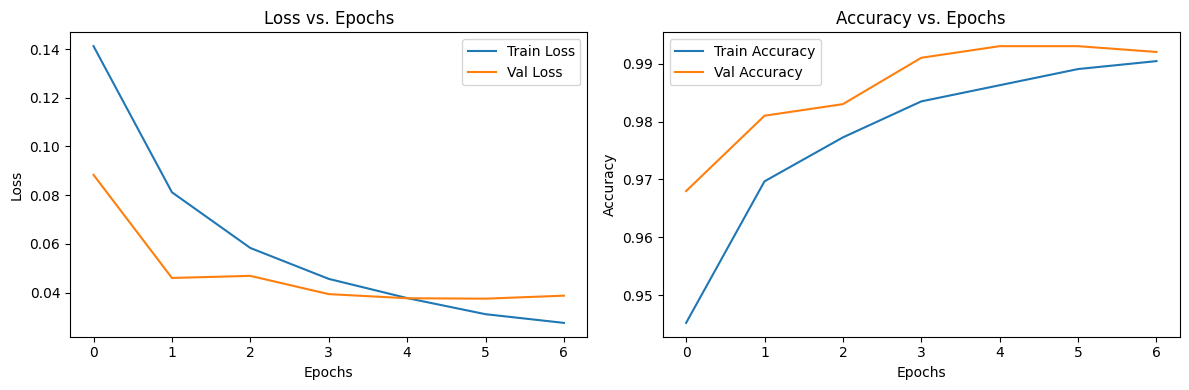

In [23]:
model, _ = train_model(train_df, val_df)

Processing mixed images: 100%|██████████| 4990/4990 [02:35<00:00, 32.09image/s]


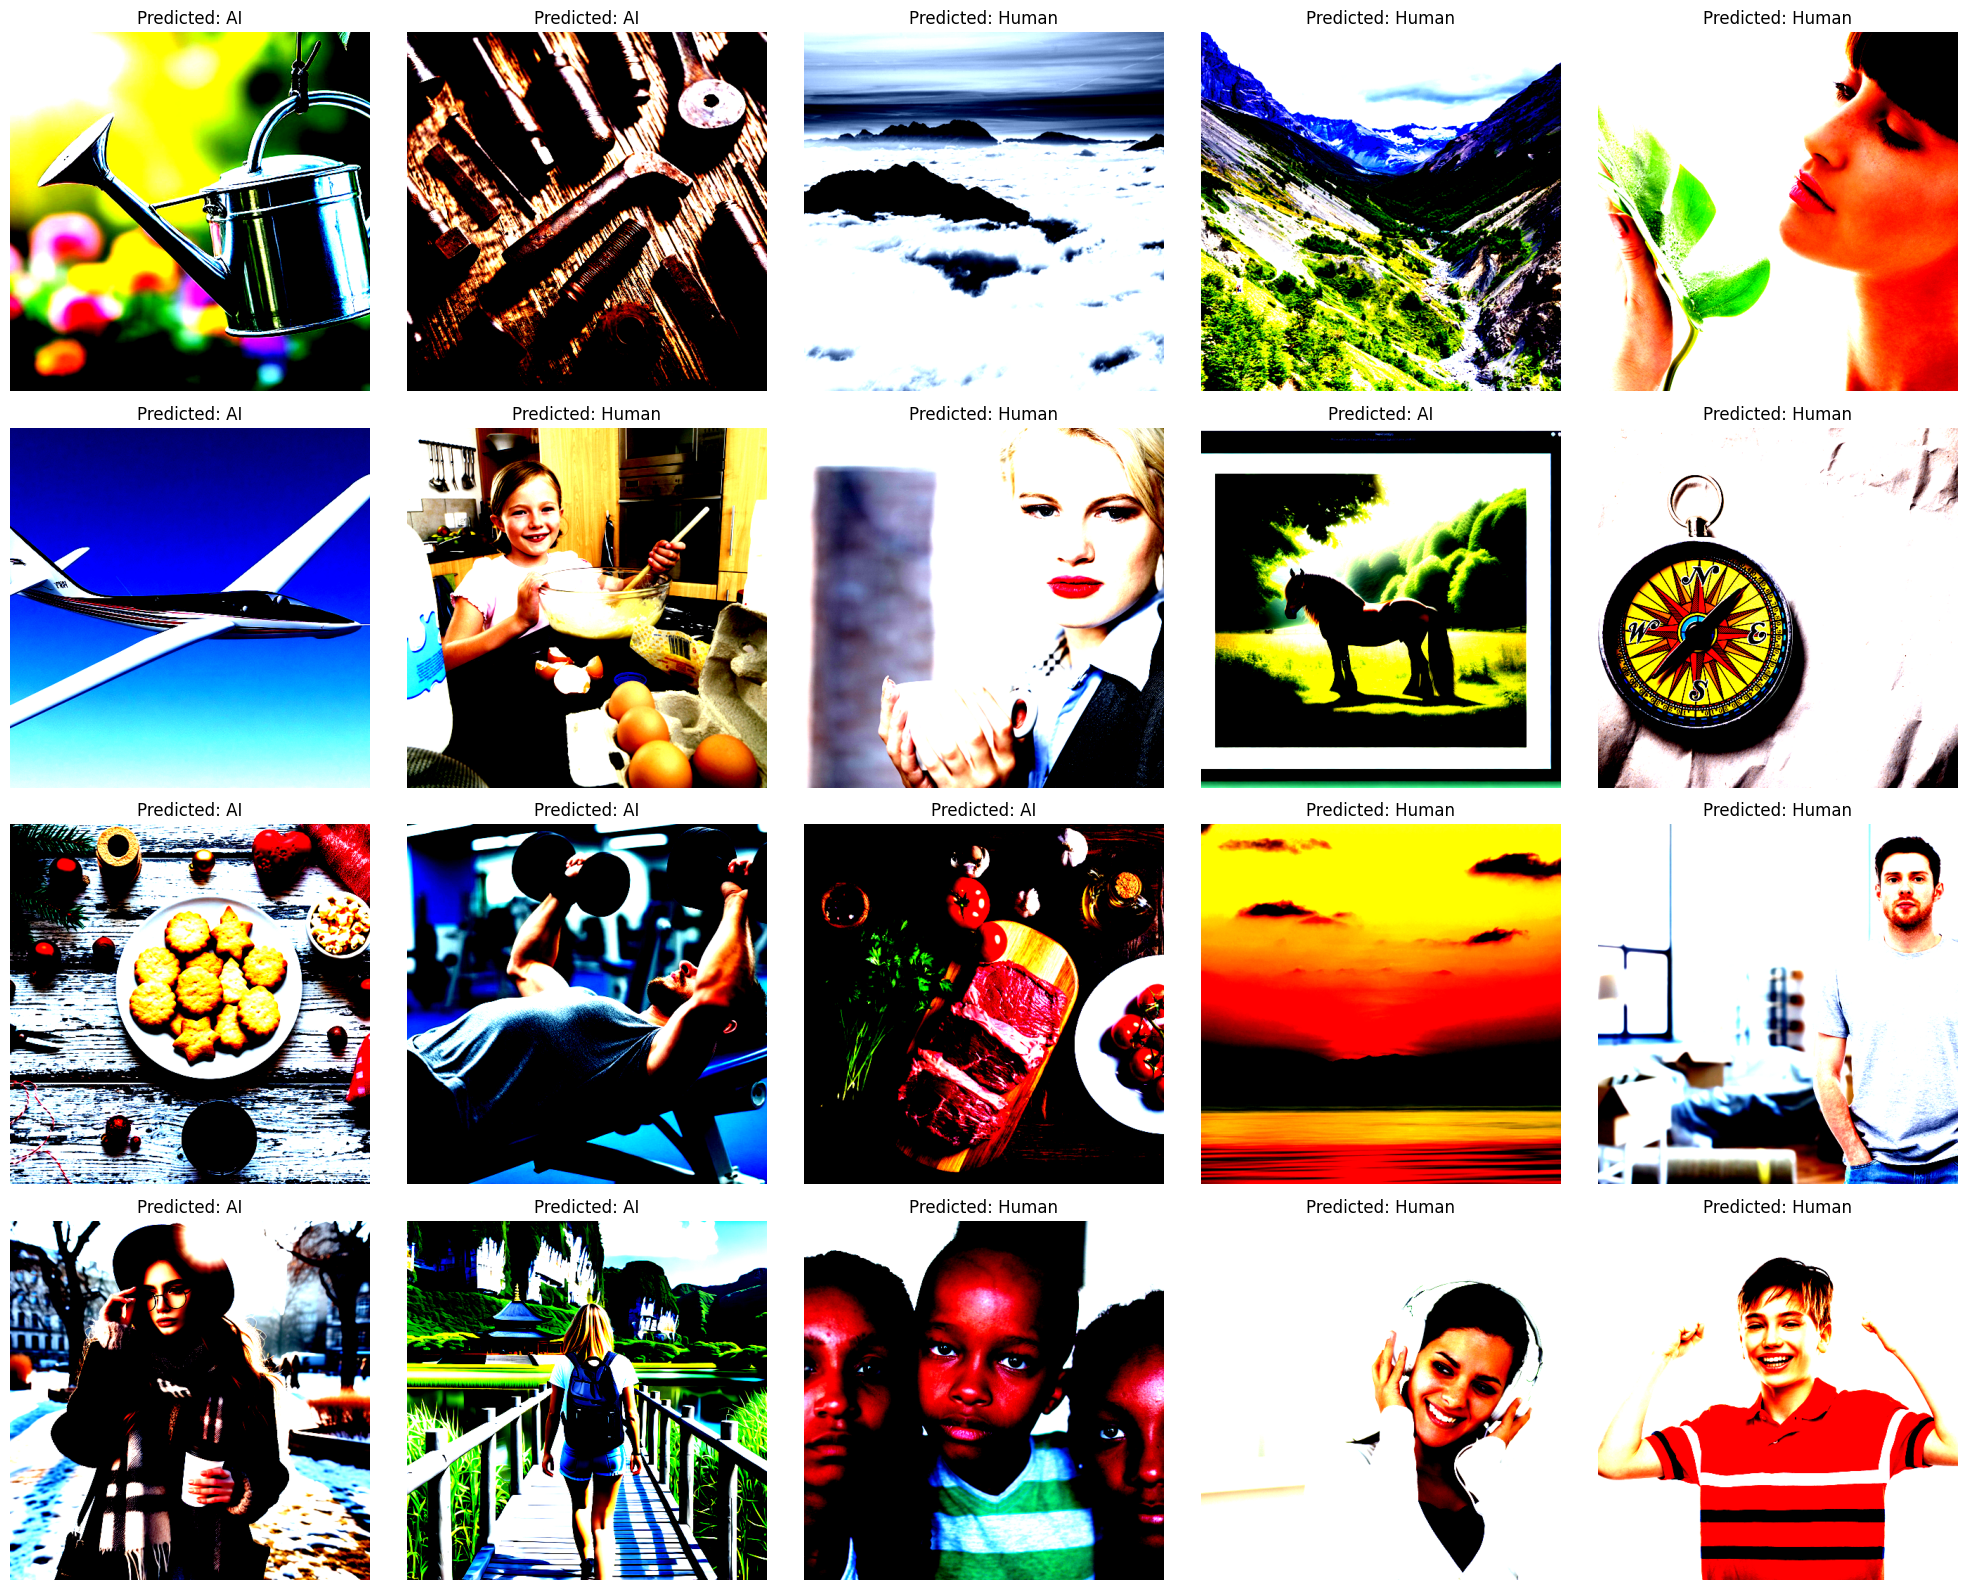

In [24]:
df_train_real_imgs = train_df[train_df['label'] == 0].copy()
submission_df, real_hist, mixed_hist, classes = create_submission_with_post_processing(
    model, CFG.test_csv_path, CFG.test_data_path, df_train_real_imgs
)

In [25]:
submission_df.to_csv('/kaggle/working/submission.csv', index=False)